# Amplitudes analysis

In [142]:
import numpy as np
from matplotlib import pyplot as plt #this is the traditional method
from statistics import stdev
from scipy.optimize import curve_fit # import method used here

Importing data from files:
- Frequencies and tension amplitudes
- Tension-time measurements (square wave) to estimate noise through generator amplitude

In [143]:
file_folder = 'data/actual data/Frequency response/'
file_name = 'amplitudes1.csv'
data_file = file_folder + file_name
frequencies, amplitudeGen, amplitudeR, amplitudeL, amplitudeC  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0, 1, 2, 3, 4), unpack = True)
folder = 'data/actual data/Voltage-time/'
file_name = 'freq19kHz.csv'
# file_name = 'squareWave100Hz.csv'
data_file = folder + file_name
squareWaveAmpGen = np.loadtxt(data_file, delimiter=',', skiprows=1, usecols=(1), unpack=True)

The data scatter plots are the following:

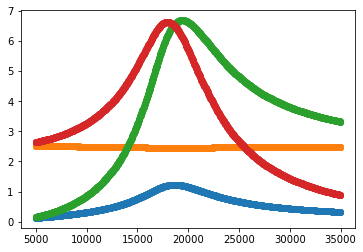

In [144]:
plt.scatter(frequencies,amplitudeR)
plt.scatter(frequencies,amplitudeGen)
plt.scatter(frequencies,amplitudeL)
plt.scatter(frequencies,amplitudeC)

We now compute $\sigma$ from data (half period since the use of a square wave) and we use it as our noise estimation.

In [145]:
swAmpPositive = []
for x in range(len(squareWaveAmpGen)):
    if (squareWaveAmpGen[x] > 0.0):
        swAmpPositive.append(squareWaveAmpGen[x])
swAmpNegative = []
for x in range(len(squareWaveAmpGen)):
    if (squareWaveAmpGen[x] < 0.0):
        swAmpNegative.append(squareWaveAmpGen[x])

sigmaPos = stdev(swAmpPositive)
sigmaNeg = stdev(swAmpNegative)
print("Deviazione standard sulle ampiezze positive della tensione del generatore: ", '{:.4f}'.format(sigmaPos))
print("Deviazione standard sulle ampiezze negative della tensione del generatore: ", '{:.4f}'.format(sigmaNeg))

# we now choose one between the two half-period calculations of sigma
ampError = []
for x in range(len(frequencies)):
    ampError.append(sigmaPos)


Deviazione standard sulle ampiezze positive della tensione del generatore:  0.0506
Deviazione standard sulle ampiezze negative della tensione del generatore:  0.0477


---
## Fitting data
We are now going to use curve_fit() method from scipy.
We now define the function we are going to fit the data with: $$ V_R = \frac{R_rV_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_L = \frac{\omega L V_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_C = \frac{\frac{V_0}{\omega C}}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$

 $\omega = 2 \pi f$ with $f$ being the sinusoidal generator frequency. We've chosen to estimate the uncertainty associated to the amplitude measures with the sample standard deviation $\sigma$ since how the DAQ program outputs the amplitude values is not known.

In [146]:
def Gen_amp_model(f, V_0):
    return V_0
def R_amp_model(f, R_r , R, L, C, V_0):
    num = R_r * V_0
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den
def L_amp_model(f, R, L, C, V_0):
    num = 2*np.pi*f * L * V_0
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den
def C_amp_model(f, R, L, C, V_0):
    num = V_0 / (2*np.pi*f * C)
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den

We now have to make our initial guess of the fitting parameters. We can make exact initial guesses or set bounds for params values

In [147]:
R_r = 996.7
R = 1.17252e+03
L = 4.741e-02
C = 1.46e-09
V_0 = 2.43

initial_guess_gen = np.array([V_0])
initial_guess_R = np.array([R_r , R, L, C, V_0])
initial_guess_L = np.array([R, L, C, V_0])
initial_guess_C = np.array([R, L, C, V_0])

boundsGen = [[0.0],[3.0]]
boundsR = [[990,990,3.5e-02,1.3e-09,0.0],[1200,2500,5e-02,1.6e-09,3.0]]
boundsL = [[990,3.5e-02,1.3e-09,0.0],[2500,5e-02,1.6e-09,3.0]]
boundsC = [[990,3.5e-02,1.3e-09,0.0],[2500,5e-02,1.6e-09,3.0]]

In [148]:
# the method returns two arrays: one with the resulting fit parameters and then the covariance matrix
fit_gen,covariance_gen = curve_fit(Gen_amp_model, frequencies, amplitudeGen,bounds=boundsGen,sigma=ampError,absolute_sigma=True)
fit_R, covariance_R = curve_fit(R_amp_model, frequencies, amplitudeR,bounds=boundsR,sigma=ampError,absolute_sigma=True)
fit_L, covariance_L = curve_fit(L_amp_model, frequencies, amplitudeL,bounds=boundsL,sigma=ampError,absolute_sigma=True)
fit_C, covariance_C = curve_fit(C_amp_model, frequencies, amplitudeC,bounds=boundsC,sigma=ampError,absolute_sigma=True)

#the elements on the the diagonal represent the errors on the fit parameters
error_gen = np.sqrt(np.diag(covariance_gen))
error_R = np.sqrt(np.diag(covariance_R))
error_L = np.sqrt(np.diag(covariance_L))
error_C = np.sqrt(np.diag(covariance_C))

### Fit results
Printing out fit results

In [149]:
print()
print('V_0    = ','{:.3f}'.format(fit_gen[0]), '±', '{:.10f}'.format(error_gen[0]), ' V')

print()
print('R_r    = ','{:.3f}'.format(fit_R[0]), '±', '{:.10f}'.format(error_R[0]), ' $\Omega$')
print('R    = ','{:.3f}'.format(fit_R[1]), '±', '{:.10f}'.format(error_R[1]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_R[2]), '±', '{:.10f}'.format(error_R[2]), ' Henry')
print('C    = ','{:.12f}'.format(fit_R[3]), '±', '{:.12f}'.format(error_R[3]), ' F')
print('V_0    = ','{:.3f}'.format(fit_R[4]), '±', '{:.10f}'.format(error_R[4]), ' V')

print()
print('R    = ','{:.3f}'.format(fit_L[0]), '±', '{:.10f}'.format(error_L[0]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_L[1]), '±', '{:.10f}'.format(error_L[1]), ' Henry')
print('C    = ','{:.12f}'.format(fit_L[2]), '±', '{:.12f}'.format(error_L[2]), ' F')
print('V_0    = ','{:.3f}'.format(fit_L[3]), '±', '{:.10f}'.format(error_L[3]), ' V')

print()
print('R    = ','{:.3f}'.format(fit_C[0]), '±', '{:.10f}'.format(error_C[0]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_C[1]), '±', '{:.10f}'.format(error_C[1]), ' Henry')
print('C    = ','{:.12f}'.format(fit_C[2]), '±', '{:.12f}'.format(error_C[2]), ' F')
print('V_0    = ','{:.3f}'.format(fit_C[3]), '±', '{:.10f}'.format(error_C[3]), ' V')


V_0    =  2.478 ± 0.0016111577  V

R_r    =  1143.172 ± 0.0000359176  $\Omega$
R    =  2029.393 ± 0.0000207885  $\Omega$
L    =  0.04735 ± 0.0007729899  Henry
C    =  0.000000001510 ± 0.000000000023  F
V_0    =  2.188 ± 0.0187644940  V

R    =  2069.108 ± 0.0000000566  $\Omega$
L    =  0.04737 ± 0.0001159237  Henry
C    =  0.000000001501 ± 0.000000000004  F
V_0    =  2.446 ± 0.0030397764  V

R    =  2056.307 ± 0.0000004961  $\Omega$
L    =  0.04702 ± 0.0001233633  Henry
C    =  0.000000001534 ± 0.000000000003  F
V_0    =  2.420 ± 0.0026868959  V


#### Graphical error visualization
We now try to visualize the covariance matrix with a colorplot:

Gen


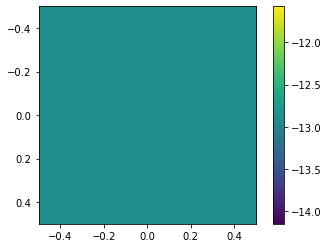

R


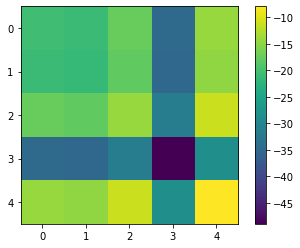

L


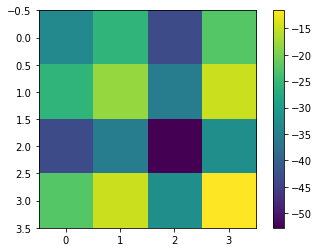

C


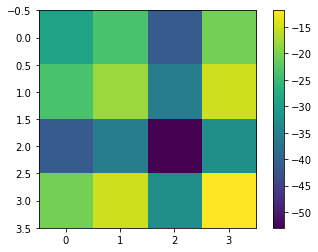

In [150]:
print('Gen')
plt.imshow(np.log(np.abs(covariance_gen)))
plt.colorbar()
plt.show()

print('R')
plt.imshow(np.log(np.abs(covariance_R)))
plt.colorbar()
plt.show()
print('L')

plt.imshow(np.log(np.abs(covariance_L)))
plt.colorbar()
plt.show()
print('C')

plt.imshow(np.log(np.abs(covariance_C)))
plt.colorbar()
plt.show()

### Fit accuracy
We are now going to evaluate the fit accuracy parameters.

In [151]:
V_gen_model = Gen_amp_model(frequencies, fit_gen[0])
residual_gen = amplitudeGen - V_gen_model
V_R_model = R_amp_model(frequencies, fit_R[0], fit_R[1], fit_R[2], fit_R[3],fit_R[4])
residual_R = amplitudeR - V_R_model
V_L_model = L_amp_model(frequencies, fit_L[0], fit_L[1], fit_L[2], fit_L[3])
residual_L = amplitudeL - V_L_model
V_C_model = C_amp_model(frequencies, fit_C[0], fit_C[1], fit_C[2], fit_C[3])
residual_C = amplitudeC - V_C_model

In [152]:
chisq_gen = sum((residual_gen/ ampError)**2)
degrees_of_freedom_gen = len(residual_gen) - len(initial_guess_gen)
reduced_chisq_gen = chisq_gen / degrees_of_freedom_gen

chisq_R = sum((residual_R/ ampError)**2)
degrees_of_freedom_R = len(residual_R) - len(initial_guess_R)
reduced_chisq_R = chisq_R / degrees_of_freedom_R

chisq_L = sum((residual_L/ ampError)**2) #typo corrected
degrees_of_freedom_L = len(residual_L) - len(initial_guess_L)
reduced_chisq_L = chisq_L / degrees_of_freedom_L

chisq_C = sum((residual_C/ ampError)**2) #typo corrected
degrees_of_freedom_C = len(residual_C) - len(initial_guess_C)
reduced_chisq_C = chisq_C / degrees_of_freedom_C

print('GEN')
print('chi-square      = ',chisq_gen)
print('degrees of freedom = ',degrees_of_freedom_gen)
print('reduced chi-square = ',reduced_chisq_gen)

print('R')
print('chi-square        = ',chisq_R)
print('degrees of freedom = ',degrees_of_freedom_R)
print('reduced chi-square = ',reduced_chisq_R)

print('L')
print('chi-square         = ',chisq_L)
print('degrees of freedom = ',degrees_of_freedom_L)
print('reduced chi-square = ',reduced_chisq_L)

print('C')
print('chi-square    = ',chisq_C)
print('degrees of freedom = ',degrees_of_freedom_C)
print('reduced chi-square = ',reduced_chisq_C)


GEN
chi-square      =  139.9554982750511
degrees of freedom =  985
reduced chi-square =  0.1420868002792397
R
chi-square        =  24.332687205510716
degrees of freedom =  981
reduced chi-square =  0.024803962492875347
L
chi-square         =  996.1732514916441
degrees of freedom =  982
reduced chi-square =  1.0144330463255031
C
chi-square    =  432.02418068252655
degrees of freedom =  982
reduced chi-square =  0.4399431575178478


## Plotting data
Now that we're done with fitting let's plot our data using [matplotlib](https://matplotlib.org).

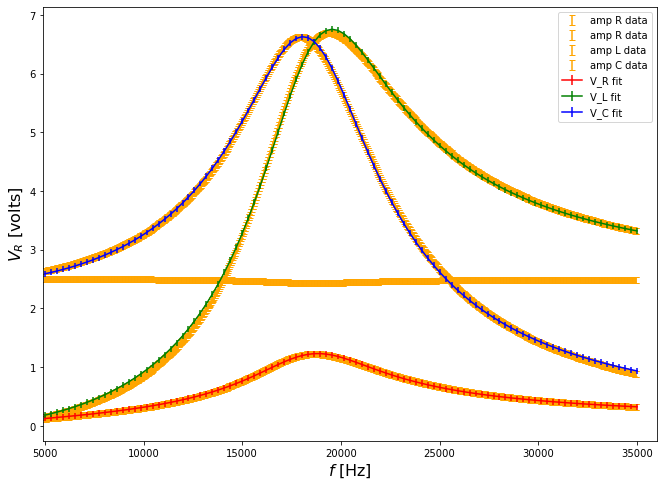

In [153]:
plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
#for default size, type plt.figure()

plt.xlabel(r"$f$ [Hz]", fontsize = 16) #label axis (using LaTeX commands)
plt.ylabel(r"$V_R$ [volts]", fontsize = 16)   #use 18 point font for label text

# Plotting the actual experimental data
plt.errorbar(frequencies, amplitudeR,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "amp R data")
plt.errorbar(frequencies, amplitudeGen,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "amp R data")
plt.errorbar(frequencies, amplitudeL,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "amp L data")
plt.errorbar(frequencies, amplitudeC,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "amp C data")

#create curve showing fit to data
freq_fit = np.linspace(5000, 35000, 100)
VR_fit = R_amp_model(freq_fit, fit_R[0], fit_R[1], fit_R[2],fit_R[3],fit_R[4])
VL_fit = L_amp_model(freq_fit, fit_L[0], fit_L[1], fit_L[2],fit_L[3])
VC_fit = C_amp_model(freq_fit, fit_C[0], fit_C[1], fit_C[2],fit_C[3])

#plotting the fitting curves
plt.errorbar(freq_fit, VR_fit, xerr = None, yerr = sigmaPos, color = 'red', label = 'V_R fit' )
plt.errorbar(freq_fit, VL_fit, xerr = None, yerr = sigmaPos, color = 'green', label = 'V_L fit' )
plt.errorbar(freq_fit, VC_fit, xerr = None, yerr = sigmaPos, color = 'blue', label = 'V_C fit' )
plt.xlim(4900 , 36000)
# plt.ylim(0.0,7.0)
# plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360],
#            ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')

plt.savefig('figs/Amplitudes-scipy.pdf')
